In [1]:
pip install -q -U keras_tuner

     |████████████████████████████████| 98 kB 4.3 MB/s 


In [2]:
# Import libraries
import sys, glob, os
import numpy as np
import scipy as sp
import pandas as pd
from csv import reader, writer
import joblib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Input, Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Reshape, LeakyReLU
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.generic_utils import get_custom_objects
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

In [3]:
# Activate GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# current working directory
cwd = '/content/drive/MyDrive/Colab Notebooks/Daylight Autonomy/'

# Data setup

In [5]:
features_file = os.path.join(cwd, 'data', 'features.csv')
targets_file = os.path.join(cwd, 'data', 'targets.csv')

In [6]:
raw_features = pd.read_csv(features_file, index_col=0)
raw_targets = pd.read_csv(targets_file)

In [7]:
minmax = np.array([[-10,10], [-10,10], [-10,10], [-10,10],
                   [-10,10], [-10,10], [-10,10], [-10,10],
                   [2,5], [0.2,0.95], [0.2,0.95], [0,360]])

In [8]:
f_avg = minmax.mean(axis=1)
f_std = minmax.std(axis=1)
t_std = 100

features = (raw_features - f_avg)/f_std
targets = raw_targets/t_std

In [9]:
features = np.array(features)
targets = np.array(targets).reshape(len(targets),40,40)

In [10]:
# Split data to train, validate, test set (60% training, 20% validation, 20% test split)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=98)

In [11]:
n_feat = features.shape[1]
n_tar = targets.shape[1]

# Model and training

In [ ]:
# Clear keras workspace for new model
keras.backend.clear_session()

# Deconvolutional Neural Network Model (DCNN) for generating daylight autonomy
model = Sequential()

### DNN model to analysis the input parameters
model.add(Dense(32 * 6 * 6, input_dim=n_feat))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(256 * 6 * 6))
model.add(BatchNormalization())
model.add(LeakyReLU())

### Deconvolution to generate image
model.add(Reshape((6, 6, 256)))

model.add(Conv2DTranspose(filters=128, kernel_size=6, strides=(2,2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64, kernel_size=6, strides=(2,2), activation='leaky-relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=1, kernel_size=5, strides=(1,1)))

# optimizer
model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss="mse")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1152)              14976     
                                                                 
 batch_normalization (BatchN  (None, 1152)             4608      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1152)              0         
                                                                 
 dense_1 (Dense)             (None, 9216)              10626048  
                                                                 
 batch_normalization_1 (Batc  (None, 9216)             36864     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 9216)              0

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs = 3000,
    batch_size = 8,
    validation_data = (X_val, y_val),
    callbacks = [
                 EarlyStopping(monitor='val_loss', patience=600, mode='min'),
                 ModelCheckpoint(filepath = 'CNN2D.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True)
    ]
)

Epoch 1/3000
75/75 [==============================] - 10s 15ms/step - loss: 0.3256 - val_loss: 0.0990
Epoch 2/3000
75/75 [==============================] - 1s 12ms/step - loss: 0.0365 - val_loss: 0.0938
Epoch 3/3000
75/75 [==============================] - 1s 12ms/step - loss: 0.0325 - val_loss: 0.0923
Epoch 4/3000
75/75 [==============================] - 1s 11ms/step - loss: 0.0360 - val_loss: 0.0424
Epoch 5/3000
75/75 [==============================] - 1s 12ms/step - loss: 0.0287 - val_loss: 0.0357
Epoch 6/3000
75/75 [==============================] - 1s 7ms/step - loss: 0.0294 - val_loss: 0.0417
Epoch 7/3000
75/75 [==============================] - 1s 12ms/step - loss: 0.0275 - val_loss: 0.0231
Epoch 8/3000
75/75 [==============================] - 1s 7ms/step - loss: 0.0271 - val_loss: 0.0281
Epoch 9/3000
75/75 [==============================] - 1s 7ms/step - loss: 0.0281 - val_loss: 0.0233
Epoch 10/3000
75/75 [==============================] - 1s 12ms/step - loss: 0.0265 - val_loss

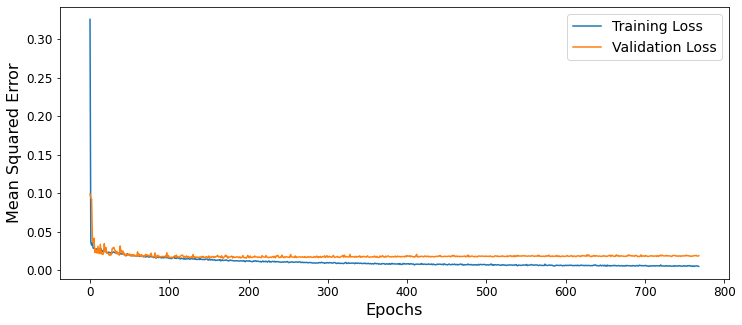

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.ylabel('Mean Squared Error',fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.legend(fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()

In [ ]:
model.load_weights('CNN2D.ckpt');

In [ ]:
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test.reshape(-1, 40*40), y_pred.reshape(-1, 40*40)))

0.12790170316022087

In [ ]:
0.1475

0.1475

In [ ]:
k = 100
q = 150

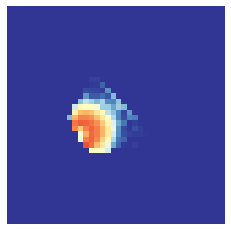

In [ ]:
plt.imshow(y_test[k], cmap='RdYlBu_r', vmax=1, vmin=0)
plt.axis('off');

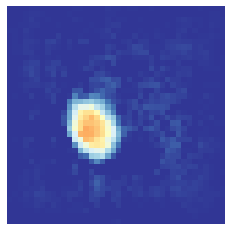

In [ ]:
plt.imshow(y_pred[k].reshape(40,-1), cmap='RdYlBu_r', vmax=1, vmin=0)
plt.axis('off');

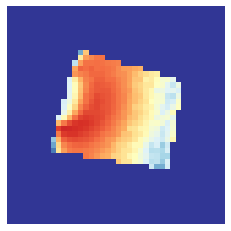

In [ ]:
plt.imshow(y_train[q], cmap='RdYlBu_r', vmax=1, vmin=0)
plt.axis('off');

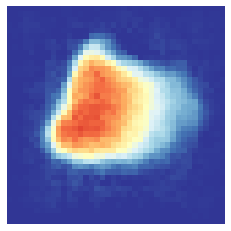

In [ ]:
y_train_pred = model.predict(X_train)
plt.imshow(y_train_pred[q].reshape(40,-1), cmap='RdYlBu_r', vmax=1, vmin=0)
plt.axis('off');

In [ ]:
np.sqrt(mean_squared_error(y_test[k],y_pred[k].reshape(40,-1)))

0.15251276005683315

In [ ]:
results = [np.sqrt(mean_squared_error(y_test[k],y_pred[k].reshape(40,-1))) for k in range(len(y_test))]    

In [ ]:
# best result
results.index(min(results))

100

In [ ]:
# worst result
results.index(max(results))

4

#Hyperparameter Tuning

In [12]:
def construct_layers(hp,n_inputs, filter_size):
    layers = []
    out = n_inputs
    i = 1
    act_fct = hp.Choice('activation', values=['relu', 'selu', 'leaky-relu'])

    while out < 40:
        # if out < 16:
        #     ins = {"input":out,
        #         "kernel":hp.Choice('kernel_' + str(i), values = [3,5,7,9]),
        #         "stride":hp.Choice('stride_' + str(i), values = [1,2])}
        if out < 33:
            ins = {"input":out,
                "kernel":hp.Choice('kernel_' + str(i), values = [3,5,7,9]),
                "stride":1,
                "activation":act_fct
                }
        else:
            ins = {"input":out,
                "kernel":41 - out,
                "stride":1,
                "activation":'None'}
        out = (out-1) * ins["stride"] + ins["kernel"]
        i += 1
        ins.update({"output":out})
        layers.append(ins)

    layers[-1]["filter"] = 1

    for ly in reversed(layers[:-1]):
        ly.update({"filter":filter_size})
        filter_size = int(filter_size*2 if filter_size<120 else filter_size)
    
    return layers

In [34]:
def generator(hp):
    # Deconvolutional Neural Network Model (DCNN) for generating daylight autonomy
    model = Sequential()

    # Construct CNN transpose layers
    hp_initsize = hp.Int('init_size', min_value=5, max_value=9)
    hp_minfilter = hp.Int('filter_size', min_value=10, max_value=20)

    CNN_layers = construct_layers(hp, hp_initsize, hp_minfilter)

    ### DNN model to analysis the input parameters
    model.add(Dense(CNN_layers[0]["filter"] * hp_initsize * hp_initsize, input_dim=12))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    ### Deconvolution to generate image
    model.add(Reshape((hp_initsize, hp_initsize, CNN_layers[0]["filter"])))

    for layer in CNN_layers[:-1]:
        model.add(Conv2DTranspose(filters=layer["filter"],
                                  kernel_size=layer["kernel"],
                                  strides=(layer["stride"],layer["stride"]),
                                  activation=layer["activation"]))
        model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(filters=CNN_layers[-1]["filter"],
                              kernel_size=CNN_layers[-1]["kernel"],
                              strides=(CNN_layers[-1]["stride"],CNN_layers[-1]["stride"]),
                              activation='sigmoid'
                              ))

    # optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    hp_epsilon = hp.Choice('epsilon', values=[1e-5, 1e-7])
    model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate, 
                                            beta_1=0.9, beta_2=0.999,
                                            epsilon=hp_epsilon), 
                  loss="mse",
                #   metrics=['mse']
                  )

    return model

In [ ]:
keras.backend.clear_session()

In [ ]:
hp = kt.HyperParameters()
hp.values["model_type"] = "cnn"

model = generator(hp)
model(X_train)
model.summary()

In [35]:
tuner = kt.Hyperband(generator,
                     objective='val_loss',
                     max_epochs=50,
                     overwrite=True)

In [36]:
tuner.search(X_train,
             y_train,
             epochs = 50,
             batch_size = 16,
             validation_data = (X_val, y_val),
             callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
             )

Trial 90 Complete [00h 00m 42s]
val_loss: 0.018124237656593323

Best val_loss So Far: 0.014660341665148735
Total elapsed time: 00h 13m 40s
INFO:tensorflow:Oracle triggered exit


In [37]:
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]

In [38]:
model = tuner.hypermodel.build(best_hp)

In [39]:
model.fit(X_train,
             y_train,
             epochs = 500,
             batch_size = 16,
             validation_data = (X_val, y_val),
             callbacks = [EarlyStopping(monitor='val_loss', patience=50, mode='min'),
                          ModelCheckpoint(filepath = 'CNN2D.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True)])

Epoch 1/500
38/38 [==============================] - 2s 24ms/step - loss: 0.1009 - val_loss: 0.1570
Epoch 2/500
38/38 [==============================] - 1s 17ms/step - loss: 0.0505 - val_loss: 0.0897
Epoch 3/500
38/38 [==============================] - 1s 17ms/step - loss: 0.0394 - val_loss: 0.0752
Epoch 4/500
38/38 [==============================] - 1s 17ms/step - loss: 0.0357 - val_loss: 0.0654
Epoch 5/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0316 - val_loss: 0.0597
Epoch 6/500
38/38 [==============================] - 1s 16ms/step - loss: 0.0297 - val_loss: 0.0547
Epoch 7/500
38/38 [==============================] - 1s 17ms/step - loss: 0.0274 - val_loss: 0.0456
Epoch 8/500
38/38 [==============================] - 1s 14ms/step - loss: 0.0269 - val_loss: 0.0505
Epoch 9/500
38/38 [==============================] - 1s 24ms/step - loss: 0.0264 - val_loss: 0.0426
Epoch 10/500
38/38 [==============================] - 1s 16ms/step - loss: 0.0244 - val_loss: 0.0378

In [40]:
model.load_weights('CNN2D.ckpt');

In [41]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [42]:
def compare_plot(sim, pred):
    results = [np.sqrt(mean_squared_error(sim[k],pred[k].reshape(40,-1))) for k in range(len(sim))]

    best_mse = min(results)
    best_idx = results.index(best_mse)

    worst_mse = max(results)
    worst_idx = results.index(worst_mse)

    fig, ax = plt.subplots(2,2,sharex=True, sharey=True, figsize=(7,7))

    ax[0,0].imshow(sim[best_idx], cmap='RdYlBu_r', vmax=1, vmin=0)
    ax[0,0].set_title('Simulation', size=15)
    ax[0,0].set_ylabel('Best Case: MSE={:.3f}'.format(best_mse), size=15)

    ax[0,1].imshow(pred[best_idx].reshape(40,-1), cmap='RdYlBu_r', vmax=1, vmin=0)
    ax[0,1].set_title('Prediction', size=15)

    ax[1,0].imshow(sim[worst_idx], cmap='RdYlBu_r', vmax=1, vmin=0)
    ax[1,0].set_ylabel('Worst Case: MSE={:.3f}'.format(worst_mse), size=15)

    ax[1,1].imshow(pred[worst_idx].reshape(40,-1), cmap='RdYlBu_r', vmax=1, vmin=0)

    ax=ax.ravel()
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_xticks([])
        a.set_yticks([])

    plt.tight_layout()

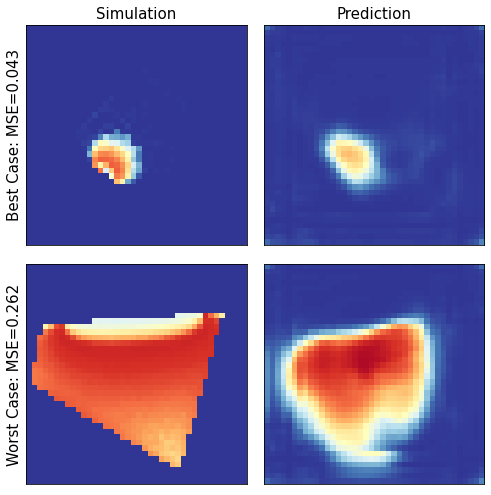

In [43]:
compare_plot(y_test, y_pred)

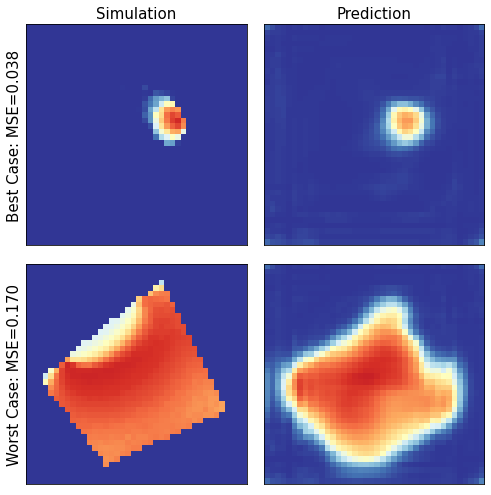

In [44]:
compare_plot(y_train, y_train_pred)

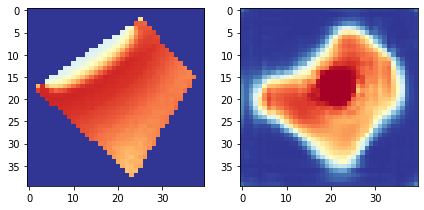

In [51]:
k=56
fig, ax = plt.subplots(1,2,figsize=(7,14))
ax[0].imshow(y_train[k], cmap='RdYlBu_r', vmax=1, vmin=0)
ax[1].imshow(y_train_pred[k].reshape(40,-1), cmap='RdYlBu_r', vmax=1, vmin=0);

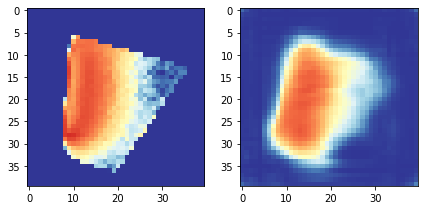

In [55]:
q=120
fig, ax = plt.subplots(1,2,figsize=(7,14))
ax[0].imshow(y_test[q], cmap='RdYlBu_r', vmax=1, vmin=0)
ax[1].imshow(y_pred[q].reshape(40,-1), cmap='RdYlBu_r', vmax=1, vmin=0);

In [ ]:
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

# Save model

In [59]:
json = os.path.join(cwd, 'models/UDI_hyperband.json')
hdf5 = os.path.join(cwd, 'models/UDI_hyperband.h5')

model_json = model.to_json()
with open(json,'w') as json_file:
    json_file.write(model_json)
model.save_weights(hdf5)

# Test for random input

In [ ]:
test_case = np.array([4.7,8,6,9.52,2.87,1.25,180,45])

test_pred = model.predict(np.expand_dims(test_case, axis=0))[0].reshape(1,-1)

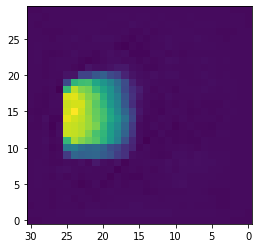

In [ ]:
plt.imshow(test_pred.reshape(30,-1))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()